## 1.Data Preparation

The purpose of this work is to train a multi-label classifier via Bert to predict MBTI personality traits.

Chi Zhang | August 2022

### Environment setup

In [1]:
!pip install -q transformers==2.3.0

     |████████████████████████████████| 447 kB 8.9 MB/s 
     |████████████████████████████████| 1.3 MB 54.9 MB/s 
     |████████████████████████████████| 880 kB 64.1 MB/s 
     |████████████████████████████████| 132 kB 52.2 MB/s 
     |████████████████████████████████| 9.1 MB 8.9 MB/s 
     |████████████████████████████████| 79 kB 4.7 MB/s 
     |████████████████████████████████| 139 kB 12.3 MB/s 
     |████████████████████████████████| 127 kB 55.6 MB/s 


In [2]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
# good output must be => ['/device:CPU:0', '/device:GPU:0']

['/device:CPU:0', '/device:GPU:0']


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_directory = './drive/MyDrive/kaggle/mbti_personality/'

In [5]:
!mkdir data
!unzip {dataset_directory}/mbti_1.csv.zip -d data/

Archive:  ./drive/MyDrive/kaggle/mbti_personality//mbti_1.csv.zip
  inflating: data/mbti_1.csv         


### Import

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = 'data/mbti_1.csv'

In [3]:
df_raw = pd.read_csv(data_path) #, encoding='cp1252')

df_raw.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
df_raw.posts[1]

"'I'm finding the lack of me in these posts very alarming.|||Sex can be boring if it's in the same position often. For example me and my girlfriend are currently in an environment where we have to creatively use cowgirl and missionary. There isn't enough...|||Giving new meaning to 'Game' theory.|||Hello *ENTP Grin*  That's all it takes. Than we converse and they do most of the flirting while I acknowledge their presence and return their words with smooth wordplay and more cheeky grins.|||This + Lack of Balance and Hand Eye Coordination.|||Real IQ test I score 127. Internet IQ tests are funny. I score 140s or higher.  Now, like the former responses of this thread I will mention that I don't believe in the IQ test. Before you banish...|||You know you're an ENTP when you vanish from a site for a year and a half, return, and find people are still commenting on your posts and liking your ideas/thoughts. You know you're an ENTP when you...|||http://img188.imageshack.us/img188/6422/6020d1f9da

Now, I want to clean the text to get rid of hyperlinks, puncuation, and anything else that's cluttering up the text. Specifically, the pipe (|) character seems like it separates different posts, but without spaces between them. First, I'm going to replace the pipes with spaces so that the tokenizer won't parse those parts as one long word. Then, I'll clean up the rest.

Code from ref: https://www.kaggle.com/code/anasofiauzsoy/myers-briggs-types-with-tensorflow-bert

In [5]:
import string
import re

def clean_text(text):
    regex = re.compile('[%s]' % re.escape('|'))
    text = regex.sub(" ", text)
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = [i for i in words if not "http" in i]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    return words

### EDA Session

In [6]:
df_raw.shape

(8675, 2)

In [7]:
types = np.unique(df_raw.type.values)

def get_type_index(string):
    return list(types).index(string)

df_raw['type_index'] = df_raw['type'].apply(get_type_index)

In [8]:
df_raw.head()

,type,posts,type_index
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,8
1,ENTP,'I'm finding the lack of me in these posts ver...,3
2,INTP,'Good one _____ https://www.youtube.com/wat...,11
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",10
4,ENTJ,'You're fired.|||That's another silly misconce...,2


In [9]:
df_raw['cleaned_text'] = df_raw['posts'].apply(clean_text)

In [10]:
df_raw.cleaned_text[1]

'im  finding  the  lack  of  me  in  these  posts  very  alarming  sex  can  be  boring  if  its  in  the  same  position  often  for  example  me  and  my  girlfriend  are  currently  in  an  environment  where  we  have  to  creatively  use  cowgirl  and  missionary  there  isnt  enough  giving  new  meaning  to  game  theory  hello  entp  grin  thats  all  it  takes  than  we  converse  and  they  do  most  of  the  flirting  while  i  acknowledge  their  presence  and  return  their  words  with  smooth  wordplay  and  more  cheeky  grins  this    lack  of  balance  and  hand  eye  coordination  real  iq  test  i  score  127  internet  iq  tests  are  funny  i  score  140s  or  higher  now  like  the  former  responses  of  this  thread  i  will  mention  that  i  dont  believe  in  the  iq  test  before  you  banish  you  know  youre  an  entp  when  you  vanish  from  a  site  for  a  year  and  a  half  return  and  find  people  are  still  commenting  on  your  posts  and  lik

In [11]:
lens = df_raw.posts.str.len()
lens.mean(), lens.std(), lens.max()

(7234.98962536023, 1607.8069375338862, 10090)

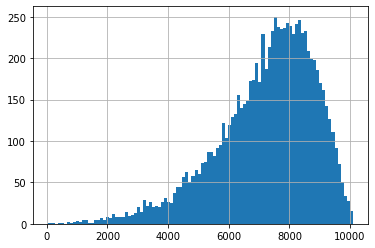

In [12]:
# distribution of text lengths
lens.hist(bins=100)

### Extracting extroversion (introversion) features and grouping into a binary column

In [13]:
df_raw['extroversion'] = df_raw.type.str.contains(r'E', na=True)
df_raw['extroversion'].replace({True:1, False:0}, inplace=True)

In [14]:
df_raw.head()

,type,posts,type_index,cleaned_text,extroversion
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,8,enfp and intj moments sportscenter not t...,0
1,ENTP,'I'm finding the lack of me in these posts ver...,3,im finding the lack of me in these pos...,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,11,good one of course to which i say i ...,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",10,dear intp i enjoyed our conversation the...,0
4,ENTJ,'You're fired.|||That's another silly misconce...,2,youre fired thats another silly misconcep...,1


### Sampling (positive:negative = 50:50)

In [15]:
df_extro = df_raw.iloc[:,3:]
df_extro.head()

,cleaned_text,extroversion
0,enfp and intj moments sportscenter not t...,0
1,im finding the lack of me in these pos...,1
2,good one of course to which i say i ...,0
3,dear intp i enjoyed our conversation the...,0
4,youre fired thats another silly misconcep...,1


In [16]:
s = df_extro.extroversion
counts=s.value_counts()
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
pd.DataFrame({'counts': counts, 'per100':percent100})

,counts,per100
0,6676,77.0%
1,1999,23.0%


In [17]:
diff_num = df_extro[df_extro.extroversion==0].shape[0]-df_extro[df_extro.extroversion==1].shape[0]

np.random.seed(42)
drop_indices = np.random.choice(df_extro[df_extro.extroversion==0].index, diff_num, replace=False)

df_extro_balanced = df_extro.drop(drop_indices)

In [18]:
s = df_extro_balanced.extroversion
counts=s.value_counts()
percent100 = s.value_counts(normalize=True).mul(100).round(1).astype(str)+'%'
pd.DataFrame({'counts': counts, 'per100':percent100})

,counts,per100
1,1999,50.0%
0,1999,50.0%


## 2. BERT Model
- Load the pretrained BERT base-model from Transformers library
- Take the first hidden-state from BERT output (corresponding to CLS token) and feed it into a Dense layer with 6 neurons and sigmoid activation (Classifier). The outputs of this layer can be interpreted as probabilities for each of the 6 classes.

In [19]:
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

bert_model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)
MAX_LEN = 1024

def tokenize_sentences(sentences, tokenizer, max_seq_len = 1024):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(df_extro_balanced['cleaned_text'], tokenizer, MAX_LEN)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)

  0%|          | 0/3998 [00:00<?, ?it/s]

In [20]:
TEST_SIZE = 0.2
label_cols = ['extroversion']
labels =  df_extro_balanced[label_cols].values

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=TEST_SIZE)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=TEST_SIZE)

train_size = len(train_inputs)
validation_size = len(validation_inputs)

In [25]:
BATCH_SIZE = 4
NR_EPOCHS = 3

def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    
    return dataset

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

In [26]:
from transformers import TFBertModel
from tensorflow.keras.layers import Dense, Flatten

class BertClassifier(tf.keras.Model):    
    def __init__(self, bert: TFBertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = Dense(num_classes, activation='sigmoid')
        
    @tf.function
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask)
        cls_output = outputs[1]
        cls_output = self.classifier(cls_output)
                
        return cls_output

model = BertClassifier(TFBertModel.from_pretrained(bert_model_name), len(label_cols))

## 3. Training Loop
- Use BinaryCrossentropy as loss function (is calculated for each of the output 6 output neurons ...that's like training 6 binary classification tasks at the same time) 
- Use the AdamW optimizer with 1-cycle-policy from the Transformers library
- AUC evaluation metrics

In [27]:
import time
from transformers import create_optimizer

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = validation_size // BATCH_SIZE

# | Loss Function
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
train_loss = tf.keras.metrics.Mean(name='train_loss')
validation_loss = tf.keras.metrics.Mean(name='test_loss')

# | Optimizer (with 1-cycle-policy)
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
optimizer = create_optimizer(init_lr=1e-5, num_train_steps=total_steps, num_warmup_steps=warmup_steps)

# | Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]
validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_cols))]

@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables), 1.0)

    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
        
@tf.function
def validation_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    for i, auc in enumerate(validation_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
                                              
def train(model, train_dataset, val_dataset, train_steps_per_epoch, val_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print('=' * 50, f"EPOCH {epoch}", '=' * 50)

        start = time.time()

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 100 == 0: #TODO: 1000
                print(f'\nTrain Step: {i}, Loss: {train_loss.result()}')
                for i, label_name in enumerate(label_cols):
                    print(f"{label_name} roc_auc {train_auc_metrics[i].result()}")
                    train_auc_metrics[i].reset_states()
        
        for i, (token_ids, masks, labels) in enumerate(tqdm(val_dataset, total=val_steps_per_epoch)):
            validation_step(model, token_ids, masks, labels)

        print(f'\nEpoch {epoch+1}, Validation Loss: {validation_loss.result()}, Time: {time.time()-start}\n')

        for i, label_name in enumerate(label_cols):
            print(f"{label_name} roc_auc {validation_auc_metrics[i].result()}")
            validation_auc_metrics[i].reset_states()

        print('\n')

        
train(model, train_dataset, validation_dataset, train_steps_per_epoch=steps_per_epoch, val_steps_per_epoch=validation_steps, epochs=NR_EPOCHS)

================================================== EPOCH 0 ==================================================


  0%|          | 0/799 [00:00<?, ?it/s]


Train Step: 0, Loss: 0.6809056997299194
extroversion roc_auc 0.0

Train Step: 100, Loss: 0.6987168788909912
extroversion roc_auc 0.48778629302978516

Train Step: 200, Loss: 0.6949121356010437
extroversion roc_auc 0.5407843589782715

Train Step: 300, Loss: 0.6823589205741882
extroversion roc_auc 0.6668416261672974

Train Step: 400, Loss: 0.6611316204071045
extroversion roc_auc 0.7492676973342896

Train Step: 500, Loss: 0.6507187485694885
extroversion roc_auc 0.7396978735923767

Train Step: 600, Loss: 0.6433594226837158
extroversion roc_auc 0.7613931894302368

Train Step: 700, Loss: 0.632028341293335
extroversion roc_auc 0.7853899002075195

Train Step: 800, Loss: 0.6219468116760254
extroversion roc_auc 0.8060965538024902

Train Step: 900, Loss: 0.6194299459457397
extroversion roc_auc 0.7946240901947021

Train Step: 1000, Loss: 0.6034748554229736
extroversion roc_auc 0.8796186447143555

Train Step: 1100, Loss: 0.5996399521827698
extroversion roc_auc 0.8552979826927185

Train Step: 1200, 

  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 1, Validation Loss: 0.7085955739021301, Time: 2964.9644191265106

extroversion roc_auc 0.8635902404785156


================================================== EPOCH 1 ==================================================


  0%|          | 0/799 [00:00<?, ?it/s]


Train Step: 0, Loss: 0.5532287359237671
extroversion roc_auc 0.9395567774772644

Train Step: 100, Loss: 0.5521206259727478
extroversion roc_auc 0.8990499973297119

Train Step: 200, Loss: 0.5490540266036987
extroversion roc_auc 0.9147284030914307

Train Step: 300, Loss: 0.5418645739555359
extroversion roc_auc 0.9432804584503174

Train Step: 400, Loss: 0.5389884114265442
extroversion roc_auc 0.9150910377502441

Train Step: 500, Loss: 0.5369762182235718
extroversion roc_auc 0.9191957116127014

Train Step: 600, Loss: 0.535595715045929
extroversion roc_auc 0.9114571809768677

Train Step: 700, Loss: 0.5339824557304382
extroversion roc_auc 0.9126601815223694

Train Step: 800, Loss: 0.5336008667945862
extroversion roc_auc 0.9153540730476379

Train Step: 900, Loss: 0.5343455672264099
extroversion roc_auc 0.8938624858856201

Train Step: 1000, Loss: 0.5322831869125366
extroversion roc_auc 0.9142877459526062

Train Step: 1100, Loss: 0.5289905667304993
extroversion roc_auc 0.9300095438957214

Trai

  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 2, Validation Loss: 0.7085961699485779, Time: 2933.5235674381256

extroversion roc_auc 0.8635902404785156


================================================== EPOCH 2 ==================================================


  0%|          | 0/799 [00:00<?, ?it/s]


Train Step: 0, Loss: 0.5138635635375977
extroversion roc_auc 0.9178351163864136

Train Step: 100, Loss: 0.5123146772384644
extroversion roc_auc 0.9250175952911377

Train Step: 200, Loss: 0.5126954317092896
extroversion roc_auc 0.9056780934333801

Train Step: 300, Loss: 0.5123962759971619
extroversion roc_auc 0.9125851392745972

Train Step: 400, Loss: 0.5116385817527771
extroversion roc_auc 0.9148246049880981

Train Step: 500, Loss: 0.5116304755210876
extroversion roc_auc 0.9000499248504639

Train Step: 600, Loss: 0.510440468788147
extroversion roc_auc 0.9232567548751831

Train Step: 700, Loss: 0.5102438926696777
extroversion roc_auc 0.9100172519683838

Train Step: 800, Loss: 0.508051872253418
extroversion roc_auc 0.9437373280525208

Train Step: 900, Loss: 0.5057647824287415
extroversion roc_auc 0.9377486109733582

Train Step: 1000, Loss: 0.505277693271637
extroversion roc_auc 0.9029277563095093

Train Step: 1100, Loss: 0.5058832168579102
extroversion roc_auc 0.9042491912841797

Train 

  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 3, Validation Loss: 0.7085961699485779, Time: 2983.9234459400177

extroversion roc_auc 0.8635902404785156




Model: "bert_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_1 (TFBertMode  multiple                 109482240 
 l)                                                              
                                                                 
 dense_1 (Dense)             multiple                  769       
                                                                 
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________


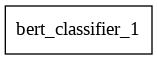

In [28]:
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')